In [1]:
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.interpolate import interp2d

import os, sys
sys.path.append("/home/pangeo/py_packages")
from ingrid.times import to_pandas
from myplots.cplot import my_contourf

# comparing precip datasets - 
# time grids
# units
# grid names
var1 = 'tp'
var2 = 'precip'
ds1 = xr.open_dataset('/net/kage/d5/datasets/ERAInterim/monthly/Accum/tp.nc',decode_times=False)
ds2 = xr.open_dataset('/net/kage/d5/datasets/GPCP/precip.mon.mean.nc')
print(list(ds1.dims),list(ds2.dims))
print(ds1[var1].shape,ds2[var2].shape)

['T', 'X', 'Y'] ['lat', 'lon', 'time']
(456, 181, 360) (442, 72, 144)


In [2]:
# RENAME the grids to match, change the time grid to match

# if statement ensures that we only rename the grids once:
if 'T' in list(ds1.dims):
    ds1 = ds1.rename({'T':'time','X':'lon','Y':'lat'})
    
ds1 = ds1.sortby('lat')
ds2 = ds2.sortby('lat')     

print('',ds1.time.coords,'\n',ds2.time.coords)

# if statement ensures that we only change the time grid once:
if 'units' in list(ds1.time.attrs):
    if 'months since' in ds1.time.units:
        print('changing to datetime64')
        ds1['time'] = to_pandas(ds1.time)
        
print('',ds1.time.coords,'\n',ds2.time.coords)

 Coordinates:
  * time     (time) float32 228.5 229.5 230.5 231.5 232.5 233.5 234.5 235.5 ... 
 Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
changing to datetime64
 Coordinates:
  * time     (time) datetime64[ns] 1979-01-16 1979-02-16 1979-03-16 ... 
 Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...


In [3]:
# Check the units of the data and change if needed

print('units in ds1:',ds1[var1].units,'  units in ds2:',ds2[var2].units)
units1 = ds1[var1].units

if units1 in 'meter second-1':
    ds1[var1] = 1000*3600*24*ds1[var1]
    ds1[var1].attrs['units']='mm/day'

units in ds1: meter second-1   units in ds2: mm/day


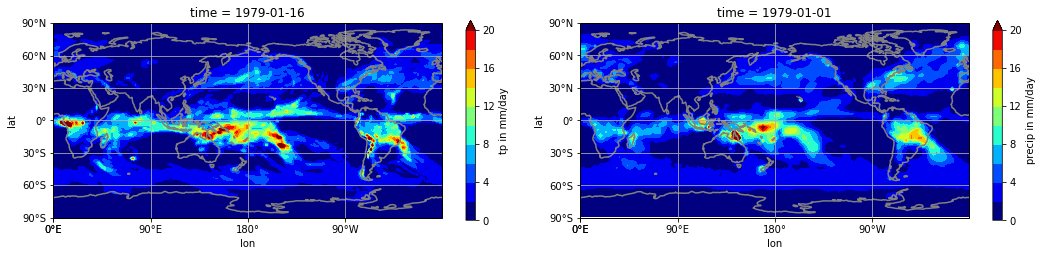

In [4]:
plt.figure(figsize=(15,4))
my_contourf(ds1[var1][0], subplot=121, vmin = 0, vmax=20, levels = 11, grid=True)
my_contourf(ds2[var2][0], subplot=122, vmin = 0, vmax=20, levels = 11, grid=True)
plt.tight_layout()

In [5]:
# Test with first time: Interpolate ds1.var1 to (ds2.lon, ds2.lat) grid 
f_tp = interp2d(ds1.lon, ds1.lat, ds1[var1][0], kind= 'linear')
new = f_tp(ds2.lon,ds2.lat)
ds2['tp2d'] = (['lat','lon'],new)
ds2['tp2d'].attrs = {'units':'mm/day'}

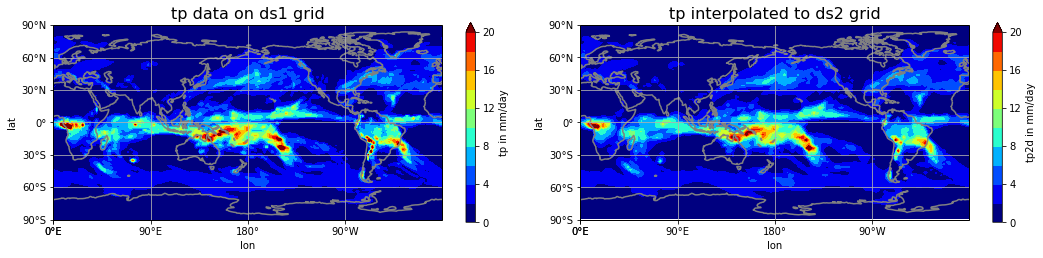

In [6]:
plt.figure(figsize=(15,4))
title = r'tp data on ds1 grid'
my_contourf(ds1[var1][0], subplot=121, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
title = r'tp interpolated to ds2 grid'
my_contourf(ds2['tp2d'],  subplot=122, vmin = 0, vmax=20, levels = 11, title = title, grid=True)
plt.tight_layout()

In [7]:
# Interpolate all of the ds1.var1 to (ds2.lon, ds2.lat) grid by looping over time

n_times = min(ds2.time.shape[0],ds1.time.shape[0])
var_interp = xr.zeros_like(ds2[var2])
for i in range(n_times):
    ftp =interp2d(ds1.lon, ds1.lat, ds1[var1][i,:,:],kind='linear')
    var_interp[i,:,:] = ftp(ds2.lon,ds2.lat)
    
var3 = var1+'_to_ds2grid'
ds2[var3] = (['time','lat','lon'],var_interp)
ds2[var3].attrs = {'units':'mm/day'}

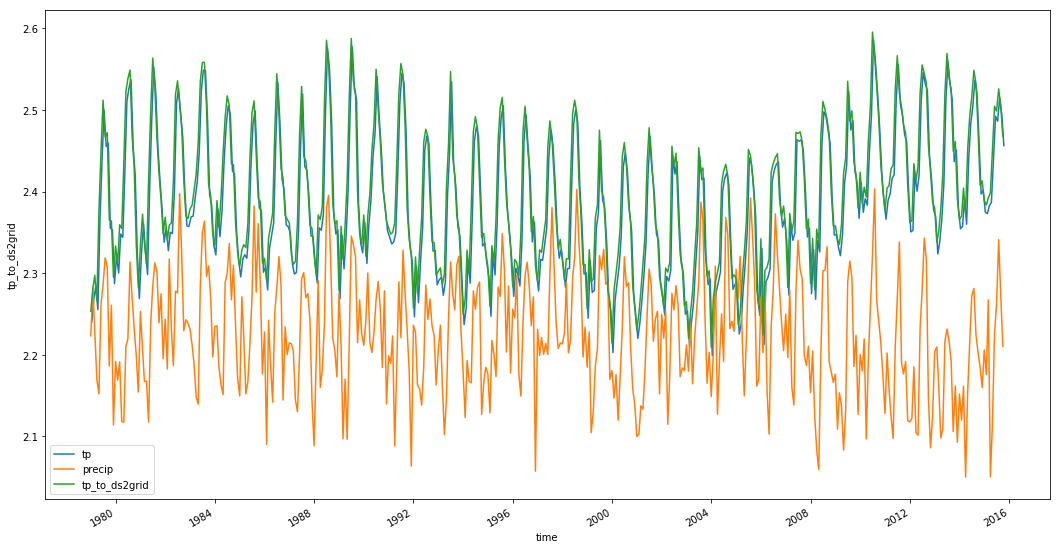

In [8]:
plt.figure(figsize=(18,10))
ds1[var1][0:n_times].mean(dim=['lon','lat']).plot()
ds2[var2][0:n_times].mean(dim=['lon','lat']).plot()
ds2[var3][0:n_times].mean(dim=['lon','lat']).plot()
plt.legend()

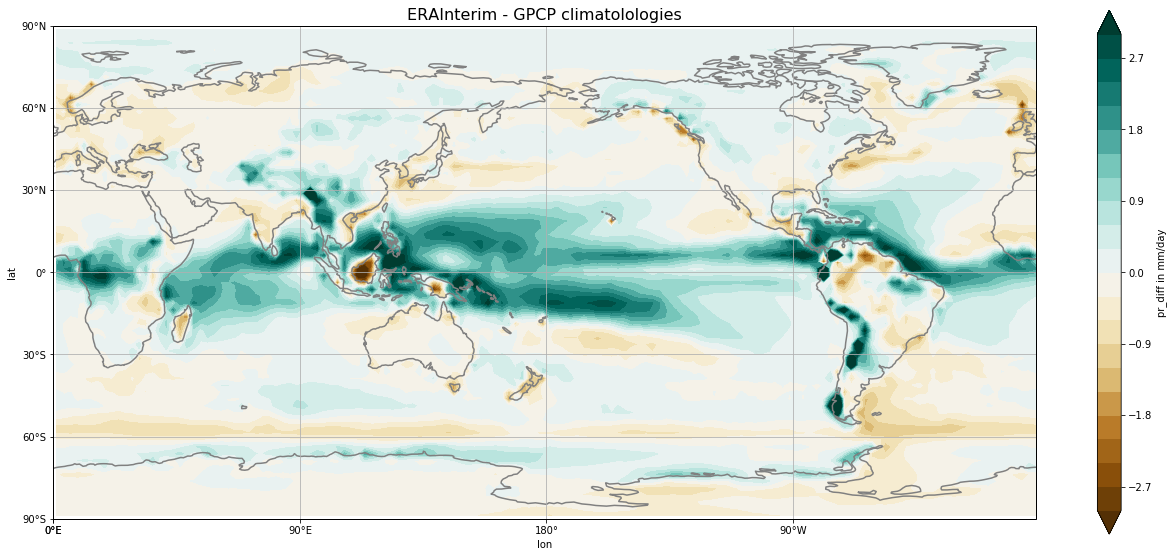

In [9]:
plt.figure(figsize=(18,10))
ptitle = r'ERAInterim - GPCP climatolologies'
ds2['pr_diff'] = (ds2[var3]-ds2[var2]).mean('time')
ds2['pr_diff'].attrs = {'units':'mm/day'}
my_contourf(ds2.pr_diff, levels = 21,
            vmin=-3, vmax=3, cmap= 'BrBG', title=ptitle, grid=True)
plt.tight_layout()